In [8]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_ollama import OllamaLLM
import re


In [9]:
# Initialize OllamaLLM
ollama_llm = OllamaLLM(model="gemma3:latest")

# System prompt to control model behavior
system_prompt = SystemMessage(content="You are a helpful assistant knowledgeable about Tintin comics. Keep your answers concise and relevant to the comics.")

# Define the state structure
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the graph builder
graph_builder = StateGraph(State)

In [10]:
# Node 1: Call the model with system prompt + full history
def node1(state: State) -> State:
    # print("node1 received:", state["messages"][-1].content)

    # Add system prompt at the start
    messages = [system_prompt] + state["messages"]

    response = ollama_llm.invoke(messages)
    return {
        "messages": [AIMessage(content=response)]
    }

In [11]:
# Node 2: Highlight "Tintin" in a way that's visible in a notebook
def node2(state: State) -> State:
    last_msg = state["messages"][-1].content
    # print("node2 received:", last_msg)

    # Highlight all whole-word instances of 'Tintin' (case-insensitive)
    highlighted_msg = re.sub(
        r'\b(Tintin)\b',
        r'🔸\1🔸',
        last_msg,
        flags=re.IGNORECASE
    )

    return {
        "messages": [AIMessage(content=highlighted_msg)]
    }

In [12]:
# Add nodes and connections
graph_builder.add_node("node1", node1)
graph_builder.add_node("node2", node2)
graph_builder.add_edge(START, "node1")
graph_builder.add_edge("node1", "node2")

graph = graph_builder.compile()

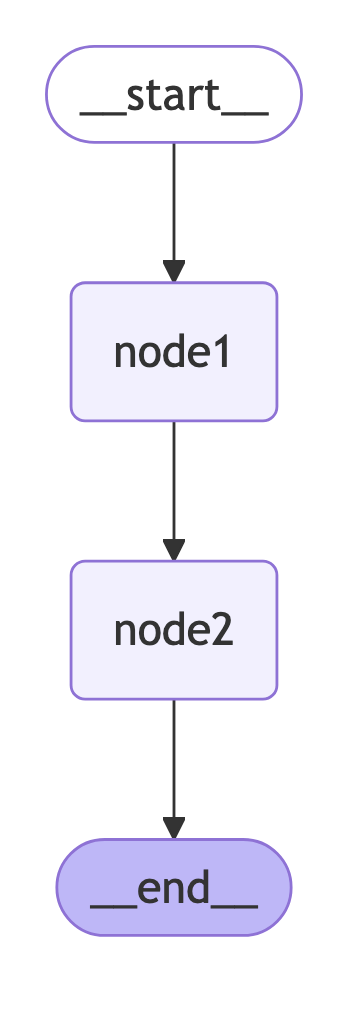

In [13]:
'''
Visualization
This part is for visualizing the graph in Jupyter Notebook
'''

import nest_asyncio # Required for Jupyter Notebook to run async functions
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod

from IPython.display import Image, display

try:
    img_data = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
    # img_data = graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)
    display(Image(data=img_data, width=60))  #Change width to scale
except Exception as e:
    print("Could not display graph:", e)

In [14]:
def stream_graph_updates(user_input: str):
    initial_state = {
        "messages": [HumanMessage(content=user_input)]
    }

    print(f"user: {user_input}")

    final_state = None
    for event in graph.stream(initial_state):
        for value in event.values():
            final_state = value  # Store latest state

    # Only show the final assistant response
    if final_state:
        last_msg = final_state["messages"][-1]
        if isinstance(last_msg, AIMessage):
            print(f"assistant: {last_msg.content}")
            
             
while True:
    try:
        user_input = input("You: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except Exception as e:
        print("Error:", e)
        break


user: Who is Snowy?
assistant: Snowy is 🔸Tintin🔸’s faithful white fox companion, always by his side on his adventures.
Goodbye!
